<a href="https://colab.research.google.com/github/kaneelgit/ML-DL-Algorithms/blob/main/contrastive_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size = '6'><center> **Contrastive Learning** </center></font>

Paper - https://arxiv.org/pdf/2002.05709.pdf

In [2]:
#import libraries
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

In [3]:
#hyperparameters
AUTO = tf.data.AUTOTUNE
bs = 32
labeled_bs = 32
test_bs = 32
epochs = 100
crop_to = 32
img_size = 32
random_seed = 26 
project_dim = 2048
latent_dim = 512
weight_decay = 0.0005

batch_size = 512

contrastive_augmentation = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.2}
classification_augmentation = {"min_area": 0.75, "brightness": 0.3, "jitter": 0.1}

In [4]:
#get the cifar-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

#normalize
x_train = x_train/255
x_test = x_test/255

#lets devide the test to labeled train and test
x_train_labeled = x_test[:5000]
y_train_labeled = y_test[:5000]

x_test = x_test[5000:]
y_test = y_test[5000:]

print(f'Total training images: {x_train.shape[0]} & Shape of training data: {x_train.shape}')
print(f'Total training labeled images: {x_train_labeled.shape[0]} & Shape of training labeled data: {x_train_labeled.shape}')
print(f'Total testing images: {x_test.shape[0]} & Shape of testing data: {x_test.shape}')

170508288/170498071 [==============================] - 8s 0us/step
Total training images: 50000 & Shape of training data: (50000, 32, 32, 3)
Total training labeled images: 5000 & Shape of training labeled data: (5000, 32, 32, 3)
Total testing images: 5000 & Shape of testing data: (5000, 32, 32, 3)


In [45]:
#class for image audmentations

class data_augmentation(layers.Layer):

  def __init__(self, **kwargs):
    super(data_augmentation, self).__init__()

  def call(self, sample):
    
    sample = self.random_apply(self.color_jitter, sample, 0.8)
    sample = self.random_apply(self.color_drop, sample, 0.2)    

    return sample

  def color_jitter(self, x, s = 1, p = 0.8):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_brightness(x, max_delta = 0.8 * s)
    x = tf.image.random_contrast(x, lower = 1 - 0.8 * s, upper = 1 + 0.8 * s)
    x = tf.image.random_saturation(x, lower = 1 - 0.8 * s, upper = 1 + 0.8 * s)
    x = tf.image.random_hue(x, max_delta = 0.2 * s)
    x = tf.clip_by_value(x, 0, 1)
    return x

  def color_drop(self, x, p = 0.2):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 1, 3])
    return x

  def random_apply(self, func, x, p):
    return tf.cond(
      tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
              tf.cast(p, tf.float32)),
      lambda: func(x),
      lambda: x)


#create the data augmentation pipline
data_aug = tf.keras.models.Sequential([tf.keras.layers.Lambda(data_augmentation()), tf.keras.layers.RandomCrop(24, 24), tf.keras.layers.Resizing(32, 32)])

In [65]:
#create tensorflow dataset objects

#create two datasets
train_ds_unlabeled = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds_unlabeled = (train_ds_unlabeled.shuffle(1024, seed = random_seed).batch(bs).prefetch(AUTO))

train_ds_labeled = tf.data.Dataset.from_tensor_slices((x_train_labeled, y_train_labeled))
train_ds_labeled = (train_ds_labeled.shuffle(1024, seed = random_seed).batch(batch_size).prefetch(AUTO))

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = (test_ds.batch(batch_size).prefetch(AUTO))

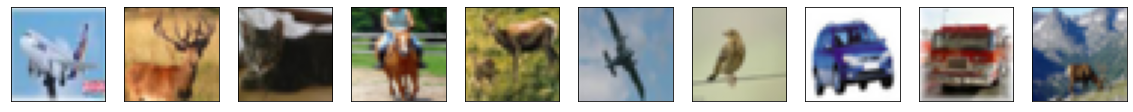

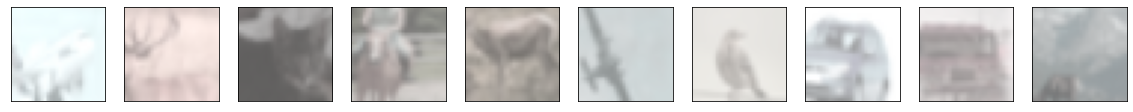

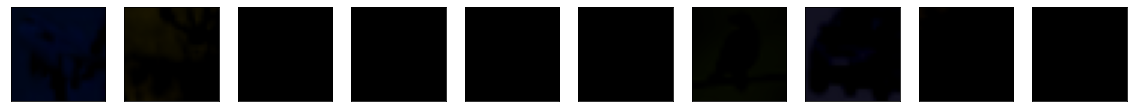

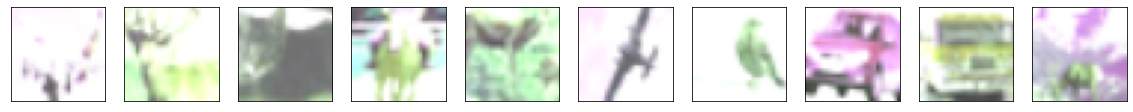

In [47]:
#checkout the augmentations
samp, lab = next(iter(train_ds_unlabeled))

def plot_images(samp):
  #plot figure
  fig, ax = plt.subplots(1, 10, figsize = (20, 2))
  
  for i, s in enumerate(samp[:10]):
    ax[i].imshow(s)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plot_images(samp)
plot_images(data_aug(samp))
plot_images(data_aug(samp))
plot_images(data_aug(samp))

In [74]:
#build the residual block 
def encoder():
  return keras.Sequential([
                           keras.Input(shape = (32, 32, 3)),
                           layers.Conv2D(16, kernel_size = 3, strides = 2, activation = 'relu'),
                           layers.Conv2D(32, kernel_size = 3, strides = 2, activation = 'relu'),
                           layers.Conv2D(64, kernel_size = 3, strides = 2, activation = 'relu'),
                           layers.Conv2D(64, kernel_size = 3, strides = 2, activation = 'relu'),
                           layers.Flatten(),
                           layers.Dense(256, activation = 'relu')])
  

#create the base model
base_model = keras.Sequential([
                               keras.Input(shape = (32, 32, 3)),
                               encoder(),
                               layers.Dense(10, activation = 'softmax')])

base_model.compile(optimizer = keras.optimizers.Adam(), loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                   metrics = [keras.metrics.SparseCategoricalAccuracy(name = 'acc')],)

In [75]:
#train the model
base_history = base_model.fit(train_ds_labeled, epochs = 25, validation_data = test_ds)


Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


10/10 [==============================] - 2s 155ms/step - loss: 2.2915 - acc: 0.1072 - val_loss: 2.2579 - val_acc: 0.1564
Epoch 2/25
10/10 [==============================] - 1s 139ms/step - loss: 2.1771 - acc: 0.1942 - val_loss: 2.0604 - val_acc: 0.2296
Epoch 3/25
10/10 [==============================] - 1s 139ms/step - loss: 2.0307 - acc: 0.2598 - val_loss: 1.9999 - val_acc: 0.2696
Epoch 4/25
10/10 [==============================] - 1s 139ms/step - loss: 1.9559 - acc: 0.2912 - val_loss: 1.9343 - val_acc: 0.3110
Epoch 5/25
10/10 [==============================] - 1s 139ms/step - loss: 1.8895 - acc: 0.3158 - val_loss: 1.8676 - val_acc: 0.3340
Epoch 6/25
10/10 [==============================] - 1s 141ms/step - loss: 1.8133 - acc: 0.3592 - val_loss: 1.8369 - val_acc: 0.3452
Epoch 7/25
10/10 [==============================] - 1s 141ms/step - loss: 1.7642 - acc: 0.3688 - val_loss: 1.7918 - val_acc: 0.3570
Epoch 8/25
10/10 [==============================] - 1s 145ms/step - loss: 1.7057 - acc:

In [ ]:
#create the SIMCLR model